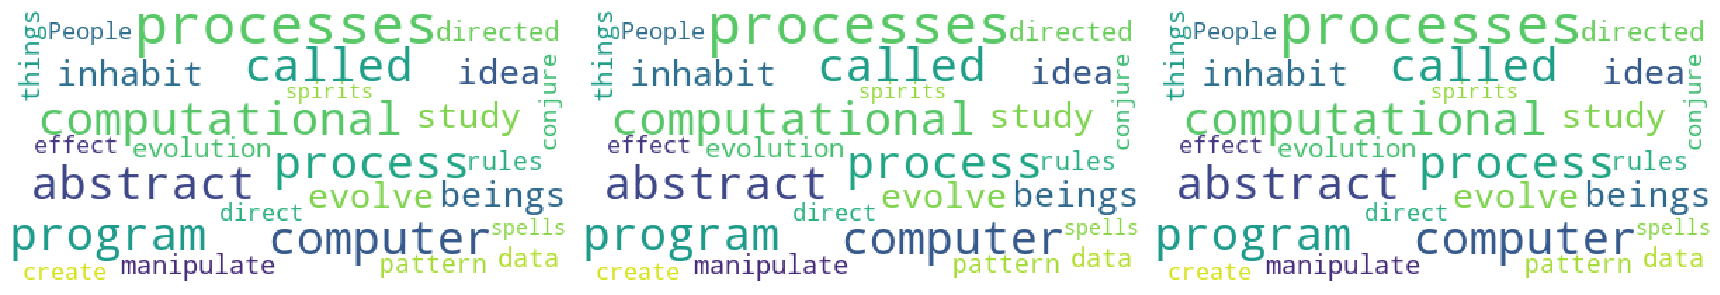

In [1]:
import re
import numpy as np
import string
import pandas as pd 
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

from subprocess import check_output
from wordcloud import WordCloud, STOPWORDS

stopwords = set(STOPWORDS)
data ="""We are about to study the idea of a computational process.
Computational processes are abstract beings that inhabit computers.
As they evolve, processes manipulate other abstract things called data.
The evolution of a process is directed by a pattern of rules
called a program. People create programs to direct processes. In effect,
we conjure the spirits of the computer with our spells."""

wordcloud = WordCloud(
                          background_color='white',
                          stopwords=stopwords,
                          max_words=200,
                          max_font_size=40, 
                          random_state=42
                         ).generate(data)

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(24, 24))
axes[0].imshow(wordcloud)
axes[0].axis('off')
axes[1].imshow(wordcloud)
axes[1].axis('off')
axes[2].imshow(wordcloud)
axes[2].axis('off')
fig.tight_layout()

<h1 id="definition" style="color:#1f9f88; background:white; border:0.5px dotted;"> 
    <center>Definition
        <a class="anchor-link" href="#definition" target="_self">¶</a>
    </center>
</h1>

**Word2vec**

Word2vec is a group of related models that are used to produce word embeddings. These models are shallow, two-layer neural networks that are trained to reconstruct linguistic contexts of words. Word2vec takes as its input a large corpus of text and produces a vector space, typically of several hundred dimensions, with each unique word in the corpus being assigned a corresponding vector in the space. Word vectors are positioned in the vector space such that words that share common contexts in the corpus are located close to one another in the space.

**CBOW**

CBOW or Continous bag of words is to use embeddings in order to train a neural network where the context is represented by multiple words for a given target words.

For example, we could use “cat” and “tree” as context words for “climbed” as the target word.<br>
This calls for a modification to the neural network architecture.<br>
The modification, shown below, consists of replicating the input to hidden layer connections C times, the number of context words, and adding a divide by C operation in the hidden layer neurons.

<h1 id="architecture" style="color:#1f9f88; background:white; border:0.5px dotted;"> 
    <center>CBOW Architecture
        <a class="anchor-link" href="#definition" target="_self">¶</a>
    </center>
</h1>

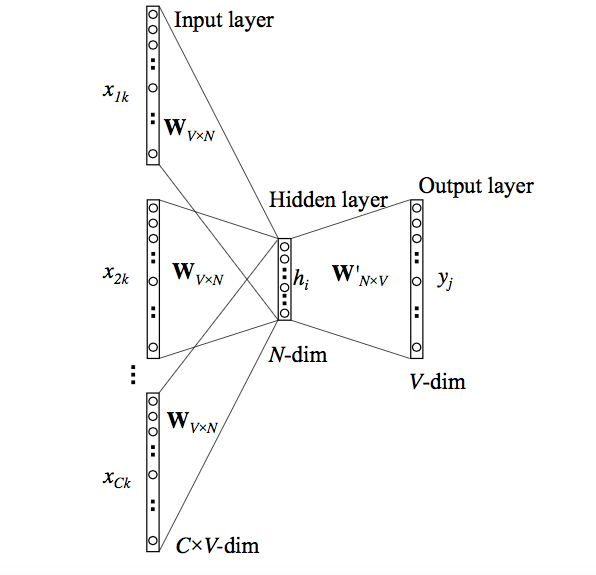

The CBOW architecture is pretty simple contains :<br>
    - the word embeddings as inputs (idx)
    - the linear model as the hidden layer
    - the log_softmax as the output

<h1 id="dataset" style="color:#1f9f88; background:white; border:0.5px dotted;"> 
    <center>Dataset
        <a class="anchor-link" href="#dataset" target="_self">¶</a>
    </center>
</h1>

In [2]:
sentences = """We are about to study the idea of a computational process.
Computational processes are abstract beings that inhabit computers.
As they evolve, processes manipulate other abstract things called data.
The evolution of a process is directed by a pattern of rules
called a program. People create programs to direct processes. In effect,
we conjure the spirits of the computer with our spells."""

### Clean Data

In [3]:
# remove special characters
sentences = re.sub('[^A-Za-z0-9]+', ' ', sentences)

# remove 1 letter words
sentences = re.sub(r'(?:^| )\w(?:$| )', ' ', sentences).strip()

# lower all characters
sentences = sentences.lower()

<h1 id="vocabulary" style="color:#1f9f88; background:white; border:0.5px dotted;"> 
    <center>Vocabulary
        <a class="anchor-link" href="#vocabulary" target="_self">¶</a>
    </center>
</h1>

In [4]:
words = sentences.split()
vocab = set(words)

In [5]:
vocab_size = len(vocab)
embed_dim = 10
context_size = 2

<h1 id="implementation" style="color:#1f9f88; background:white; border:0.5px dotted;"> 
    <center>Implementation
        <a class="anchor-link" href="#implementation" target="_self">¶</a>
    </center>
</h1>

### Dictionaries

In [6]:
word_to_ix = {word: i for i, word in enumerate(vocab)}
ix_to_word = {i: word for i, word in enumerate(vocab)}

### Data bags

In [7]:
# data - [(context), target]

data = []
for i in range(2, len(words) - 2):
    context = [words[i - 2], words[i - 1], words[i + 1], words[i + 2]]
    target = words[i]
    data.append((context, target))
print(data[:5])

[(['we', 'are', 'to', 'study'], 'about'), (['are', 'about', 'study', 'the'], 'to'), (['about', 'to', 'the', 'idea'], 'study'), (['to', 'study', 'idea', 'of'], 'the'), (['study', 'the', 'of', 'computational'], 'idea')]


### Embeddings

In [8]:
embeddings =  np.random.random_sample((vocab_size, embed_dim))

### Linear Model

In [9]:
def linear(m, theta):
    w = theta
    return m.dot(w)

### Log softmax + NLLloss = Cross Entropy

In [10]:
def log_softmax(x):
    e_x = np.exp(x - np.max(x))
    return np.log(e_x / e_x.sum())

In [11]:
def NLLLoss(logs, targets):
    out = logs[range(len(targets)), targets]
    return -out.sum()/len(out)

In [12]:
def log_softmax_crossentropy_with_logits(logits,target):

    out = np.zeros_like(logits)
    out[np.arange(len(logits)),target] = 1
    
    softmax = np.exp(logits) / np.exp(logits).sum(axis=-1,keepdims=True)
    
    return (- out + softmax) / logits.shape[0]

### Forward function

In [13]:
def forward(context_idxs, theta):
    m = embeddings[context_idxs].reshape(1, -1)
    n = linear(m, theta)
    o = log_softmax(n)
    
    return m, n, o

### Backward function

In [14]:
def backward(preds, theta, target_idxs):
    m, n, o = preds
    
    dlog = log_softmax_crossentropy_with_logits(n, target_idxs)
    dw = m.T.dot(dlog)
    
    return dw

### Optimize function

In [15]:
def optimize(theta, grad, lr=0.03):
    theta -= grad * lr
    return theta

<h1 id="training" style="color:#1f9f88; background:white; border:0.5px dotted;"> 
    <center>Training
        <a class="anchor-link" href="#training" target="_self">¶</a>
    </center>
</h1>

In [16]:
theta = np.random.uniform(-1, 1, (2 * context_size * embed_dim, vocab_size))

In [17]:
epoch_losses = {}

for epoch in range(80):

    losses =  []

    for context, target in data:
        context_idxs = np.array([word_to_ix[w] for w in context])
        preds = forward(context_idxs, theta)

        target_idxs = np.array([word_to_ix[target]])
        loss = NLLLoss(preds[-1], target_idxs)

        losses.append(loss)

        grad = backward(preds, theta, target_idxs)
        theta = optimize(theta, grad, lr=0.03)
        
     
    epoch_losses[epoch] = losses

<h1 id="analyze" style="color:#1f9f88; background:white; border:0.5px dotted;"> 
    <center>Analyze
        <a class="anchor-link" href="#analyze" target="_self">¶</a>
    </center>
</h1>

### Plot loss/epoch

Text(0, 0.5, 'Losses')

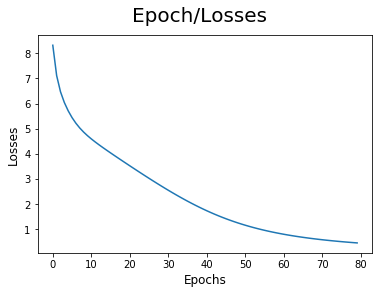

In [18]:
ix = np.arange(0,80)

fig = plt.figure()
fig.suptitle('Epoch/Losses', fontsize=20)
plt.plot(ix,[epoch_losses[i][0] for i in ix])
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Losses', fontsize=12)

### Predict function

In [19]:
def predict(words):
    context_idxs = np.array([word_to_ix[w] for w in words])
    preds = forward(context_idxs, theta)
    word = ix_to_word[np.argmax(preds[-1])]
    
    return word

In [20]:
# (['we', 'are', 'to', 'study'], 'about')
predict(['we', 'are', 'to', 'study'])

'about'

### Accuracy

In [21]:
def accuracy():
    wrong = 0

    for context, target in data:
        if(predict(context) != target):
            wrong += 1
            
    return (1 - (wrong / len(data)))

In [22]:
accuracy()

1.0

<h1 id="more" style="color:#1f9f88; background:white; border:0.5px dotted;"> 
    <center>Learn more
        <a class="anchor-link" href="#more" target="_self">¶</a>
    </center>
</h1>

If you want to learn more on NLP starter, feel free to visit [Neptune AI blog page](https://neptune.ai/blog/word-embeddings-guide)